In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [5]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

In [6]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

In [7]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [8]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [9]:
check_env_specs(env)
num_cells = 256

2024-05-19 18:24:30,368 [torchrl][INFO] check_env_specs succeeded!


In [10]:
# creo la rete neurale dell'attore 

actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

In [11]:
#Per consentire alla politica di "dialogare" con l'ambiente tramite il vettore di dati tensordict, avvolgiamo il nn.Module in un TensorDictModule. 
# ==> classe che prende  le in_keys che le vengono fornite e scriverà i risultati sul posto nelle out_keys registrate.
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [12]:
# Ora dobbiamo costruire una distribuzione a partire dalla posizione e dalla scala della nostra distribuzione normale.
# Per farlo, istruiamo la classe ProbabilisticActor a costruire una TanhNormal utilizzando i parametri di posizione e scala. 
# Diamo minimo e massimo di questa distribuzione, che otteniamo dalle specifiche dell'ambiente.

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
    
)

#NB: avremo bisogno del log-prob per il numeratore dei pesi di importanza

In [13]:
# Value network
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [14]:
# Fissiamo questi due iperparametri (iniziamo con quelli dati da pyhtorch)
frames_per_batch = 1000
# Pytorch suggerisce "For a complete training, bring the number of frames up to 1M"
total_frames = 50_000

In [15]:
#TorchRL fornisce una serie di classi DataCollector.
#tre operazioni:
#resettano un ambiente, 
#calcolano un'azione data l'ultima osservazione
#eseguono un passo nell'ambiente
#ripetono gli ultimi due passaggi fino a quando l'ambiente segnala uno stop (o raggiunge uno stato di completamento).

dummy_input = torch.zeros(1, *env.transform[0].loc.shape, device=device)
policy_module(dummy_input)
value_module(dummy_input)

collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [16]:
#(contesti on-policy) un replay buffer viene riempito ogni volta che viene raccolto un batch di dati
# e i suoi dati vengono consumati ripetutamente per un certo numero di epoche.
#I replay buffer di TorchRL sono costruiti utilizzando un contenitore comune chiamato ReplayBuffer.
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [17]:
# Importo la ClipPPOLoss.
# per restituire le perdite della politica e del valore servono le seguenti operazioni:
# (1) costruire il modulo del vantaggio, che utilizza il nostro operatore di valore
# (2) passare ogni batch di dati attraverso di esso prima di ogni epoca.
# GAE aggiorna il tensordict di input con nuove voci "advantage" e "value_target". 
# "value_target": tensore senza gradiente che rappresenta il valore empirico che la rete di valore dovrebbe rappresentare con l'osservazione di input.

# fissiamo alcuni iperparametri, partendo da quelli suggeriti da pytorch
clip_epsilon = 0.2
entropy_eps = 1e-4
gamma = 0.99
lmbda = 0.95
lr = 3e-4


advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

Ecco tutti gli elementi necessari per codificare il nostro ciclo di addestramento. I passaggi includono:

1. **Raccogliere dati**
    - **Calcolare il vantaggio**
        
        a. **Loop sui dati raccolti per calcolare i valori di perdita**

        b. **Propagare all'indietro**
        
        c. **Ottimizzare**
        
        d. **Ripetere**
    - **Ripetere**
2. **Ripetere**


In [18]:
# partiamo inizializzando alcuni iperparametri
sub_batch_size = 64
num_epochs = 10
max_grad_norm = 1.0

In [19]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# Iteriamo sul collector finché non raggiunge il numero totale di frame
# che è stato progettato per raccogliere:
for i, tensordict_data in enumerate(collector):
    # Impariamo dal batch di dati con cui lavorare
    for _ in range(num_epochs):
        # ci serve un segnale "vantaggio" per far funzionare PPO,
        # che ricalcoliamo a ogni epoca perchè dipende dalla value
        # network che viene aggiornata nel ciclo interno
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Ottimizzazione: retropropagazione, clpi del gradiente e step di ottimizzazione
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # Valutiamo la politica una volta ogni 10 batch di dati.
        # 1 - eseguiamo la politica senza esplorazione
        # 2 - (prendiamo il valore atteso della distribuzione delle azioni) per un dato
        #      numero di passi (1000, che è il nostro orizzonte di ``env``).
        # Il metodo ``rollout`` dell'``env`` può prendere una politica come argomento:
        # e la esegue ad ogni passo.

        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # rollout con la trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # Stiamo anche utilizzando un programmatore del tasso di apprendimento.
    # Come il clipping del gradiente, che è vantaggioso ma non è necessario affinché PPO funzioni.

    scheduler.step()

eval cumulative reward:  222.8093 (init:  101.8440), eval step-count: 23, average reward= 9.3087 (init= 9.0901), step count (max): 65, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:24<00:00, 184.02it/s]

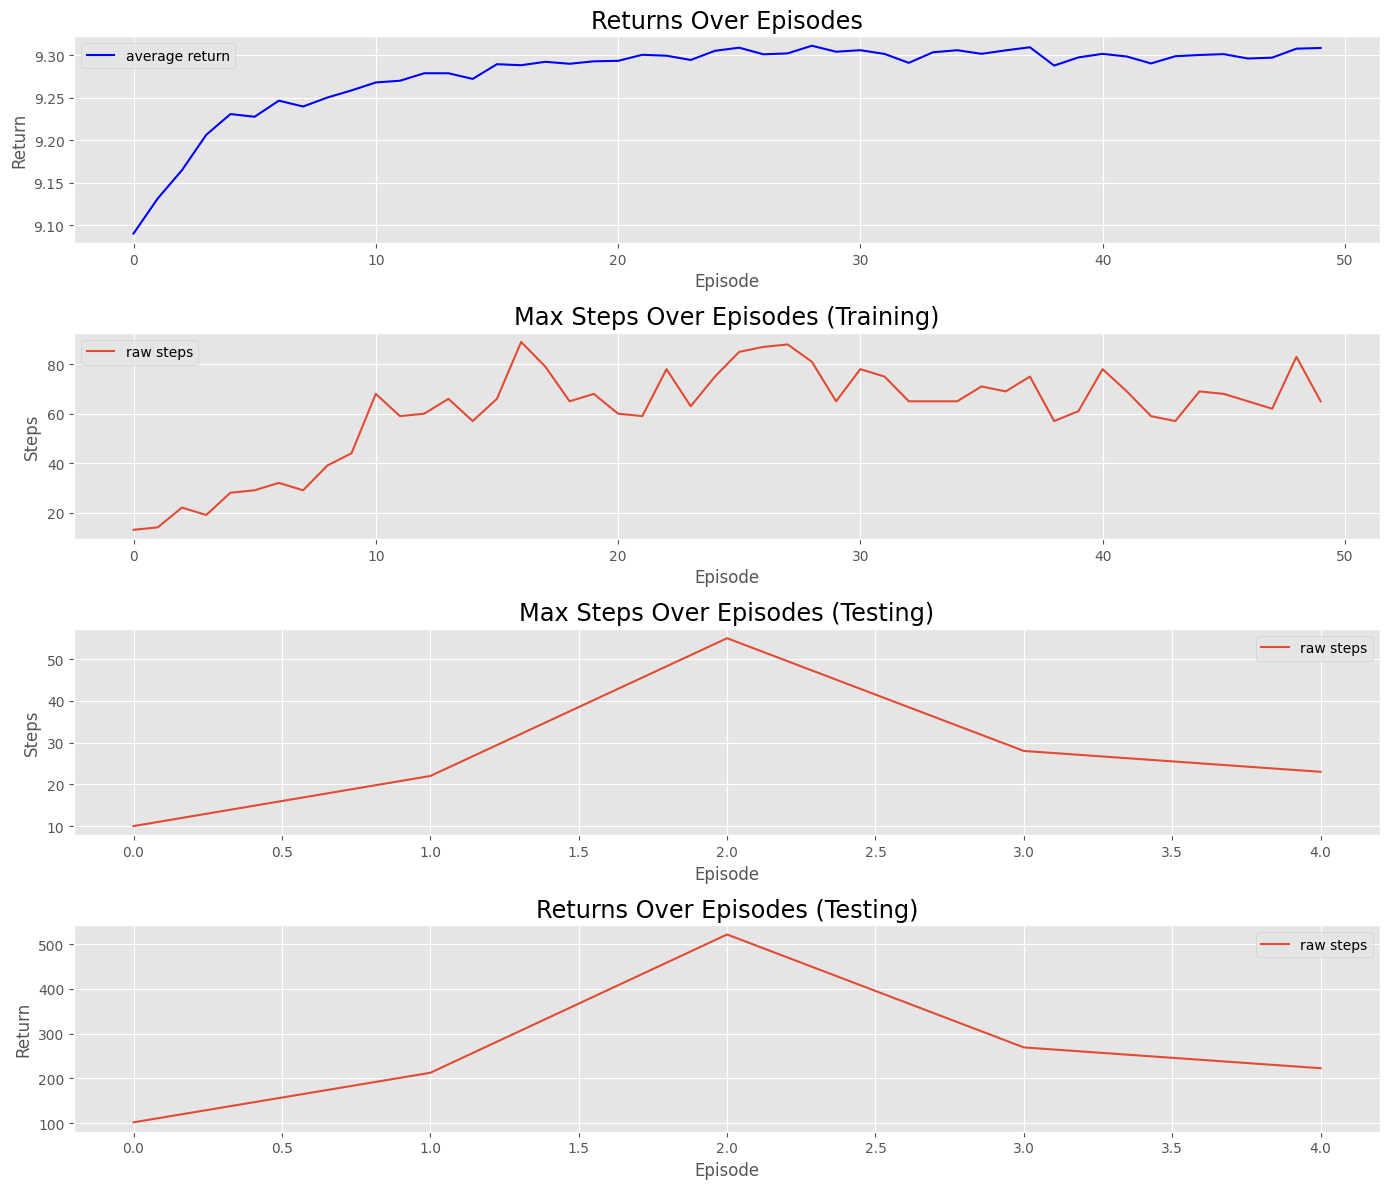

In [28]:
plt.style.use('ggplot')
ma_window = 50
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), tight_layout=True)

# Plot 1
ax1.plot(logs["reward"], label='average return', color='blue')
ax1.set_title('Returns Over Episodes', fontsize='xx-large')
ax1.set_xlabel('Episode')
ax1.legend()
ax1.set_ylabel('Return')

# Plot 2
ax2.plot(logs["step_count"], label='raw steps')
#ax2.plot(pd.Series(logs["step_count"]).rolling(ma_window).mean(), label=f'moving average window={ma_window}', color='blue')
ax2.set_title('Max Steps Over Episodes (Training)', fontsize='xx-large')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.legend()

# Plot 3
ax3.plot(logs["eval step_count"], label='raw steps')
ax3.set_title('Max Steps Over Episodes (Testing)', fontsize='xx-large')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Steps')
ax3.legend()

# Plot 4
ax4.plot(logs["eval reward (sum)"], label='raw steps')
ax4.set_title('Returns Over Episodes (Testing)', fontsize='xx-large')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Return')
ax4.legend()


plt.show()

In [30]:
# Salviamo il modello
torch.save(policy_module.state_dict(), "models\\ppo_policy.pth")